# pystrat-tutorial

This Jupyter notebook is intended to demonstrate core *pystrat* functionality.

The *pystrat* package is available here: https://github.com/yuempark/pystrat

Note that all data used in this notebook is modified or fabricated for instructional purposes, and does not accurately reflect real collected data.

*A note on figure workflows:*

You can save any figure by adding the following line before the `plt.show()` command:

```python
plt.savefig('<name_of_figure>.pdf')
```

The format of the saved figure is specified with the extension of the file name (example above uses pdf).

By default, matplotlib exports figures with all labels and text annotations converted to vector paths. However, it is often preferable to preserve these as text objects so that font, font size, etc. can easily be manipulated when importing the figure into Illustrator, for example. To do this, add one of the following lines (depending on your preferred format) to a new cell and execute it.

```python
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42
```

In [1]:
# standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pystrat
from pystrat import pystrat

## Quick Start

To come...

## Organizing your Data

**Read in the measured section.**

In this case, the data is stored in a .csv:

In [2]:
litho = pd.read_csv('example-data/lithostratigraphy.csv')
litho.head()

,THICKNESS,FACIES,LITHOLOGY,COLOR,FEATURES
0,14.8,sts,si,purple,NaN
1,0.2,tuff,tuff,tuff,NaN
2,1.5,sts,si,purple,NaN
3,4.8,cover,cover,cover,NaN
4,3.7,sts,si,purple,NaN


---
**Initialize a `Section` object.**

A measured stratigraphic section is fundamentally comprised of discrete units, each with a their own stratigraphic thickness and facies. *pystrat* and the `Section` object is built upon this fundamental framework.

Therefore, we initialize the `Section` object with the stratigraphic thicknesses and facies of these units, extracted from the pandas dataframe we read in above:

In [3]:
section_01 = pystrat.Section(litho['THICKNESS'], litho['FACIES'])

---
**Access `Section` attributes.**

*pystrat* takes advantage of object oriented programming (OOP). After initialization, a `Section` object will automatically have a few basic attributes:

* `thicknesses`
    * stratigraphic thicknesses of each unit
* `facies`
    * facies of each unit
* `n_units`
    * number of units
* `total_thickness`
    * total stratigraphic thickness
* `base_height`
    * stratigraphic height at the base of each unit
* `unique_facies`
    * unique facies
* `n_unique_facies`
    * number of unique facies
* `facies_attributes`
    * names of attributes associated with the stratigraphic units
* `data_attributes`
    * names of attributes associated with the stratigraphic height (see below)
* `generic_attributes`
    * names of generic attributes associated with neither the stratigraphic height nor the stratigraphic units (see below)
    
These attributes can be accessed in the following way:

In [4]:
section_01.total_thickness

2435.5

---
**Add attributes associated with the stratigraphic units.**

Often, there will be additional data associated with the units in the stratigraphic section.

We can add an arbitrary number of such attributes using the `add_facies_attribute()` method:

In [5]:
section_01.add_facies_attribute('lithology', litho['LITHOLOGY'])
section_01.add_facies_attribute('color', litho['COLOR'])
section_01.add_facies_attribute('features', litho['FEATURES'])

Again, these attributes can then be accessed in the following way (slicing out the first 5 values for illustrative purposes):

In [6]:
section_01.color[:5]

array(['purple', 'tuff', 'purple', 'cover', 'purple'], dtype=object)

---
**Recover attributes associated with the stratigraphic units.**

The attributes associated with the stratigraphic units can be easily recovered using the `return_facies_dataframe()` method:

In [7]:
facies_dataframe = section_01.return_facies_dataframe()
facies_dataframe.head()

,unit_number,thicknesses,base_height,facies,lithology,color,features
0,0,14.8,0.0,sts,si,purple,NaN
1,1,0.2,14.8,tuff,tuff,tuff,NaN
2,2,1.5,15.0,sts,si,purple,NaN
3,3,4.8,16.5,cover,cover,cover,NaN
4,4,3.7,21.3,sts,si,purple,NaN


---
**Add attributes associated with the stratigraphic height.**

Often, there will also be data tied to the stratigraphic height rather than the stratigraphic units. *pystrat* organizes such data using the `Data` subclass.

A typical example of such an attribute would be chemostratigraphic data. Here, we read in some chemostratigraphic data:

In [8]:
chemo = pd.read_csv('example-data/chemostratigraphy.csv')
chemo.head()

,CARB_SAMPLE,CARB_HEIGHT,CARB_d13C,CARB_d18O
0,sample_001,1.5,0.766,-0.814
1,sample_002,5.6,1.737,0.893
2,sample_003,12.0,1.882,0.732
3,sample_004,21.4,1.398,-0.682
4,sample_005,25.5,1.661,-0.516


Add the $\delta^{13}$C data using the `add_data_attribute()` method:

In [9]:
section_01.add_data_attribute('d13C', chemo['CARB_HEIGHT'], chemo['CARB_d13C'])

This will create a `Data` subclass with the following attributes:

* `height`
    * stratigraphic height of the data
* `values`
    * values of the data
* `n_values`
    * number of values
* `height_attributes`
    * names of attributes associated with this array of stratigraphic heights
* `generic_attributes`
    * names of generic attributes associated with this `Data` object
    
These attributes can be accessed in the following way:

In [10]:
section_01.d13C.n_values

275

We can also add further attributes to this particular `Data` subclass using the `add_height_attribute()` method (for example, the sample names associated with the $\delta^{13}$C data):

In [11]:
section_01.d13C.add_height_attribute('sample', chemo['CARB_SAMPLE'])

Again, we can access these new attributes in the following way (slicing out the first 5 values for illustrative purposes):

In [12]:
section_01.d13C.sample[:5]

array(['sample_001', 'sample_002', 'sample_003', 'sample_004',
       'sample_005'], dtype=object)

And we can recover them using the `return_data_dataframe()` method:

In [13]:
d13C_dataframe = section_01.d13C.return_data_dataframe()
d13C_dataframe.head()

,height,values,sample
0,1.5,0.766,sample_001
1,5.6,1.737,sample_002
2,12.0,1.882,sample_003
3,21.4,1.398,sample_004
4,25.5,1.661,sample_005


We can follow the same workflow to add a separate dataset tied to the stratigraphic height - in this case geochronology samples:

In [14]:
geochron = pd.read_csv('example-data/geochronology.csv')
geochron.head()

,ASH_SAMPLE,ASH_HEIGHT,ASH_AGE
0,ash_sample_04,138.3,850.0
1,ash_sample_05,159.4,NaN
2,ash_sample_06,462.4,NaN
3,ash_sample_07,470.0,810.0
4,ash_sample_01,911.7,NaN


In [15]:
section_01.add_data_attribute('ages', geochron['ASH_HEIGHT'], geochron['ASH_AGE'])
section_01.ages.add_height_attribute('sample', geochron['ASH_SAMPLE'])

---
**Add generic attributes.**

We can also add generic attributes to the `Section` that are neither tied to the stratigraphic height nor the stratigraphic units using the `add_generic_attribute()` method.

For example, here we add an attribute that contains the stratigraphic formations that were measured in this section:

In [16]:
section_01.add_generic_attribute('formations', ['Formation 1','Formation 2'])
section_01.formations

['Formation 1', 'Formation 2']

## Setting the Styling

To plot a stratigraphic section, the `Section` must be accompanied by a compatible `Style`. This `Style` class organizes the plotting style specified by the user.

**Read in the styling.**

In this case, the plotting style is specified in two .csv's, with the intention that the plotted color of the units will be based on the `color` attribute we added to the `Section`, and the plotted width of the units will be based on the `facies` attribute we added to the `Section`.

In [17]:
color_style = pd.read_csv('example-data/color-style.csv')
color_style.head()

,COLOR,r,g,b
0,purple,200,134,210
1,tuff,255,211,220
2,cover,255,255,255
3,green,43,182,115
4,purple-green,130,170,255


In [18]:
width_style = pd.read_csv('example-data/width-style.csv')
width_style.head()

,FACIES,width
0,sts,0.30
1,tuff,1.00
2,cover,0.20
3,sts-tuff,0.30
4,sts-vfss,0.35


---
**Initialize a `Style` object.**

Values need to be assigned to seven core attributes during initialization:

* `color_attribute`
    * `Section` attribute name from which the color labels are derived
* `color_labels`
    * the labels to which colors are assigned
* `color_values`
    * the colors that will be assigned to the associated labels
* `width_attribute`
    * `Section` attribute name from with the width labels are derived
* `width_labels`
    * the labels to which widths are assigned
* `width_values`
    * the widths that will be assigned to the associated labels
* `height_scaling_factor`
    * the factor by which the height units of a `Section` will be converted to inches during plotting
* `width_inches`
    * when plotting, a width value of 1 will be this many inches wide
    
Note that:

* `color_attribute` and `width_attribute` must be valid attributes within the `Section` you are trying to plot
* the values within the associated `Section` attribute must form a subset of the `color_labels` and `width_labels`
* `color_values` can take any form that is interpretable by *matplotlib* (in this example, we use RGB values)
* `width_values` must be between 0 and 1

In [19]:
style_01 = pystrat.Style('color',color_style['COLOR'],color_style[['r','g','b']]/255,
                         'facies',width_style['FACIES'],width_style['width'],
                         0.004, 1)

---
**Visualize the `Style`.**

We can create a legend for any `Style` using the `plot_legend()` method:

stratigraphic height scaling : 1 inch = 1 distance unit * 0.004
width value of 1 will be     : 1 inches


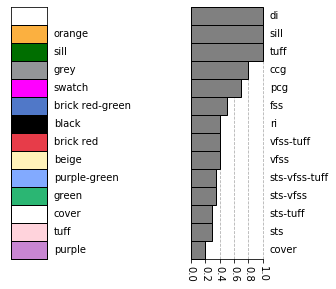

In [20]:
fig, ax = style_01.plot_legend()

plt.show(fig)

## Plotting a Section

**Check that the `Section` is compatible with the `Style`.**

As described above, the `Style` must specify attributes and labels that are compatible with any given `Section`. The `section_style_compatibility()` function tests this compatibility:

In [21]:
pystrat.section_style_compatibility(section_01, style_01)

Section and Style are compatible.


---
**Plot the `Section`**.

Plotting a stratigraphic section on its own is straight-forward - we simply use the `plot_stratigraphy()` function.

Importantly, the height of the axis is explicitly set by the `height_scaling_factor` value in the associated `Style` object, and the width of the axis is explicitly set by the `width_inches` value in the associated `Style` object. Therefore, all sections that are plotted using the same `Style` will have exactly the same scaling ratio applied to the stratigraphic height, and therefore be directly compared to one another.

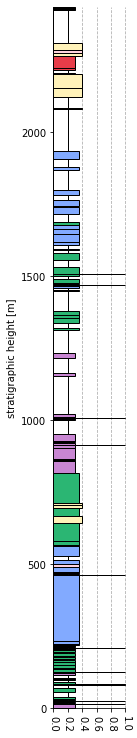

In [22]:
fig, ax = pystrat.plot_stratigraphy(section_01, style_01)

plt.show(fig)

---
**Plotting additional data.**

Additional data can be plotted alongside the stratigraphic section by changing `ncols` in the `plot_stratigraphy()` function, in a manner similar to that when using `plt.subplots()`. Additional data can then easily be plotted on top of these pre-generated axes:

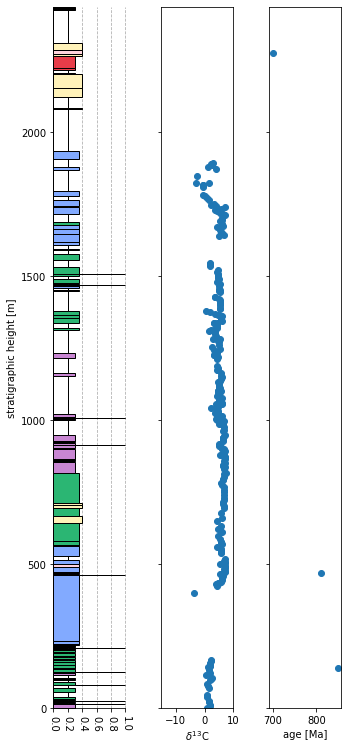

In [23]:
fig, ax = pystrat.plot_stratigraphy(section_01, style_01, ncols=3)

ax[1].scatter(section_01.d13C.values, section_01.d13C.height)
ax[1].set_xlim(-15,10)
ax[1].set_xlabel('$\delta^{13}$C')

ax[2].scatter(section_01.ages.values, section_01.ages.height)
ax[2].set_xlabel('age [Ma]')

plt.show(fig)

# Needs Review

Due to the new OOP system.

## Plot a Stratigraphic Section

Import the data - note that it must follow the formatting of `data_template.csv`. The data .csv must contain at least two headers: one of these headers MUST be named 'THICKNESS'. Other columns may be named whatever the user desires.

pystrat functions used:

* `read_data`

In [ ]:
data = read_data('templates/data_template.csv', header=4)
data.head()

Import the formatting - note that it must follow the formatting of `formatting_template.csv`:

* Columns 1-4 are used to set the colour of the boxes
    * columns 1-3 must be called `r`, `g`, and `b` (for red, green, and blue), and values in columns 1-3 must be between 0-255
    * the header of column 4 must match one of the headers used in the data .csv, and all values in the data must be a subset of the values in this column
* Columns 6-7 are used to set the width of the boxes
    * column 6 must be called `width`
    * the header of column 7 must match one of the headers used in the data .csv, and all values in the data must be a subset of the values in this column
    * column 5 should be left blank for readability.

pystrat functions used:

* `read_formatting`

In [ ]:
formatting = read_formatting('templates/formatting_template.csv')

Integrity check - check that values in the data are a subset of values in the formatting:

pystrat functions used:

* `integrity_check`

In [ ]:
integrity_check(data, formatting)

Plot:

pystrat functions used:

* `initiate_figure`
* `add_data_axis`

In [ ]:
# set up the strat ratio which sets the vertical scale of the section
strat_ratio = 0.004

# initiate the figure and set size
fig, ax = initiate_figure(data, formatting, strat_ratio, figwidth=12,
                          width_ratios=[1,1,1,1,0.5,0.5], linewidth=0.5)

# add data for d13C
add_data_axis(fig, ax, 2, data['CARB_d13C'], data['CARB_HEIGHT'], 'scatter')
ax[2].set_xlabel('$\delta^{13}$C')
ax[2].set_xlim(-15,10)
ax[2].set_xticks([-15,-10,-5,0,5,10])
ax[2].xaxis.grid(ls='--')

# add data for d18O
add_data_axis(fig, ax, 3, data['CARB_d18O'], data['CARB_HEIGHT'], 'scatter',
              color='orange')
ax[3].set_xlabel('$\delta^{18}$O')
ax[3].set_xlim(-20,5)
ax[3].set_xticks([-20,-15,-10,-5,0,5])
ax[3].xaxis.grid(ls='--')

# add height of paleomag samples
add_data_axis(fig, ax, 4, np.zeros(len(data['PM_HEIGHT'])), data['PM_HEIGHT'],
              'scatter', color=[0.8, 0.2, 0.6])
ax[4].set_xticks([])
ax[4].set_title('pmag sites')

# add height of ash samples
add_data_axis(fig, ax, 5, np.zeros(len(data['ASH_HEIGHT'])), data['ASH_HEIGHT'],
              'scatter', color='#AF4A34',marker='*')
ax[5].set_xticks([])
ax[5].set_title('ash')

plt.show(fig)

## LOWESS Fitting

Locally weighted scatter plot smoothing. To perform the basic LOWESS:

pystrat functions used:

* `lowess_fit`

In [ ]:
# the LOWESS fit
height_LOWESS, d13C_LOWESS = lowess_fit(data['CARB_HEIGHT'], data['CARB_d13C'], frac=0.5)

# plot the results
fig, ax = plt.subplots(figsize=(10,3))

ax.scatter(data['CARB_HEIGHT'], data['CARB_d13C'], c='C7', label='data')
ax.plot(height_LOWESS, d13C_LOWESS, c='C1', lw=3, label='LOWESS')
ax.yaxis.grid(ls='--')
ax.set_xlabel('stratigraphic height [m]')
ax.set_ylabel('$\delta^{13}$C')
ax.legend()

plt.show(fig)

To normalize the data against the LOWESS fit:

pystrat functions used:

* `lowess_normalize`

In [ ]:
# the LOWESS fit
height_LOWESS, d13C_LOWESS, d13C_norm = lowess_normalize(data['CARB_HEIGHT'], data['CARB_d13C'], frac=0.5)

# plot the results
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,7))

ax[0].scatter(data['CARB_HEIGHT'], data['CARB_d13C'], c='C7', label='data')
ax[0].plot(height_LOWESS, d13C_LOWESS, c='C1', lw=3, label='LOWESS')
ax[0].yaxis.grid(ls='--')
ax[0].set_ylabel('$\delta^{13}$C')
ax[0].legend()

ax[1].scatter(data['CARB_HEIGHT'], d13C_norm, c='C1', label='normalized data')
ax[1].yaxis.grid(ls='--')
ax[1].set_ylabel('normalized $\delta^{13}$C')
ax[1].legend()

plt.show(fig)

## Calculate Stratigraphic Thickness

Given the following for the start and end points, calculate a stratigraphic thickness between two points:

* latitude (decimal degrees)
* longitude (decimal degrees)
* elevation (m)
* strike of bedding (RHR)
* dip of bedding

pystrat functions used:

* `calculate_stratigraphic_thickness`

In [ ]:
# the data
lat = (28.00181863, 28.00386025)
lon = (108.7997006, 108.8009878)
elev = (1159, 1167)
strike = (342, 335)
dip = (41, 36)

d = calculate_stratigraphic_thickness(lat, lon, elev, strike, dip)

print('The stratigraphic distance between the two points is: ' + str(np.round(d,2)) + ' m')

If you have a .csv with a number of stratigraphic thicknesses that need to be calculated, there is a function for that too. Note that the .csv must follow the formatting of `covers_template.csv`:

pystrat functions used:

* `calculate_stratigraphic_thickness_csv`

In [ ]:
covers = calculate_stratigraphic_thickness_csv('templates/covers_template.csv')
covers

## Calculate Distance to Specified Units

Calculate the closest stratigraphic distance of each sample to a set of units:

pystrat functions used:

* `distance_to_units`

In [ ]:
# let's say we are interested in seeing how close the samples are to either 'cover' or 'tuff' units
units = ['cover', 'tuff']

# the header of the column in 'data' in which to find the units in 'units'
unit_header = 'GRAIN_SIZE'

# run the function
unit_d = distance_to_units(data, data['CARB_HEIGHT'], units, unit_header)

We can plot the data, with samples within, say, 60cm of the specified units coloured differently:

In [ ]:
# initiate the figure
fig, ax = initiate_figure(data, formatting, strat_ratio, 6, [1,1], linewidth=0.5, features=False)

# add data for d13C that is below the threshold
add_data_axis(fig, ax, 1, data[unit_d<0.6]['CARB_d13C'], data[unit_d<0.6]['CARB_HEIGHT'], 'scatter',
              color='C1', label='<60cm')

# add data for d13C that is above the threshold
add_data_axis(fig, ax, 1, data[unit_d>=0.6]['CARB_d13C'], data[unit_d>=0.6]['CARB_HEIGHT'], 'scatter',
              color='C7', label='>=60cm')

# prettify
ax[1].set_xlabel('$\delta^{13}$C')
ax[1].set_xlim(-15,10)
ax[1].set_xticks([-15,-10,-5,0,5,10])
ax[1].xaxis.grid(ls='--')
ax[1].legend()

plt.show(fig)

## Assign Units to Samples

The functionality described here is useful if the user wishes to assign a stratigraphic unit (taken from the data .csv) to collected samples. This function also corrects for addition/subtraction errors made in the field, and assigns the correct stratigraphic height to collected samples.

Note that this function has been designed specifically around sample collection/logging conventions used in the Swanson-Hysell Group, and may not apply if your conventions differ:

* the `recorded_height` parameter is the height of each sample as recorded in the field
* the `remarks` parameter is used to denote calculation errors made in the field
    * if the true height of the sample is X m above the recorded height, write `ADD X`
    * if the true height of the sample is X m below the recorded height, write `SUB X`
    * these corrections only need to be noted at the first sample where the correction comes into effect (i.e. it will apply to all following samples until a new remark is found)
    
Below is an example of the recommended way to apply these functions:

pystrat functions used:

* `sample_curate`

In [ ]:
# do the calculations
data_sample_info = sample_curate(data, data['CARB_SAMPLE'], data['CARB_REMARKS'])

The code will flag samples that are on unit boundaries by adding 0.5 to the unit number. User input is required to correctly identify which unit these samples belong to:

* if the sample comes from the lower unit, subtract 0.5
* if the sample comes from the upper unit, add 0.5

To make this manual process easier, the following snippet of code prints the code necessary to make adjustments to the unit number:

pystrat functions used:

* `print_unit_edit_code`

In [ ]:
# print the code needed to edit samples that are on unit boundaries
print_unit_edit_code(data_sample_info, 'data_sample_info')

# also show the recorded height and true height of these samples
mask = (data_sample_info['unit'] != np.floor(data_sample_info['unit']))
data_sample_info[mask]

Copy and paste the code that was printed by `print_unit_edit_code` into a new cell (as below), and edit the unit numbers as appropriate:

In [ ]:
data_sample_info.loc[101,'unit'] = 77
data_sample_info.loc[120,'unit'] = 81
data_sample_info.loc[257,'unit'] = 126

To save the correct height and sample unit to the original data .csv, you can simply copy and paste the output table to the original data .csv:

In [ ]:
pd.set_option("display.max_rows",9999)
data_sample_info